In [192]:
%matplotlib inline
import sys
import copy
import datetime as dt
import darts
from darts import TimeSeries

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


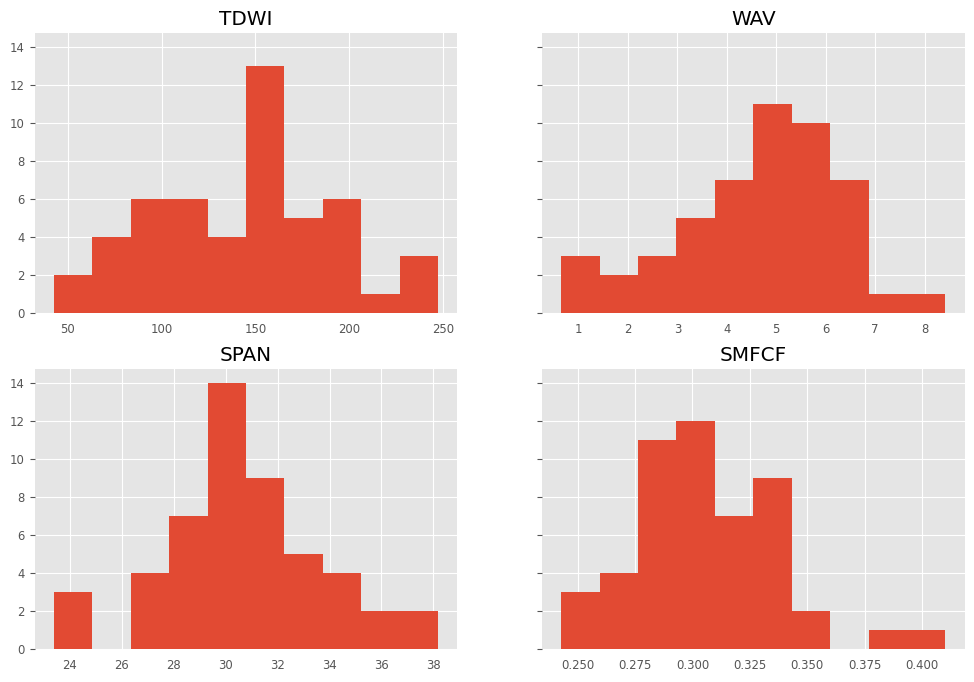

In [193]:
ensemble_size = 50
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

In [194]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

In [195]:
for i, member in enumerate(ensemble):
    member.run_till_terminate()

In [196]:
results = [pd.DataFrame(member.get_output()) for member in ensemble]

In [197]:
from darts.models import LinearRegressionModel, RandomForest, VARIMA, ExponentialSmoothing, ARIMA, LightGBMModel
from darts.utils.utils import ModelMode
from darts.dataprocessing.transformers.scaler import Scaler

forecasters = []

SPLIT = 20
for result_df in results:
    filtered_df = result_df[["TWLV", "LAI", "SM"]]
    series = TimeSeries.from_dataframe(filtered_df)
    train_cols = ["LAI", "SM"]
    #train_cols = ["SM"]

    add_encoders={
        'cyclic': {'future': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'transformer': Scaler(),
        'tz': 'CET'
    }
    
    train_series, test_series = series[train_cols][:-SPLIT], series[train_cols][-SPLIT:]
    past_covariates, future_covariates = series[["TWLV"]][:-36], series[["TWLV"]][-36:]

    forecaster = LinearRegressionModel(30, add_encoders=add_encoders)
    forecaster.fit(train_series)
    forecasters.append(forecaster)

In [198]:
pred_dfs = []
for forecaster in forecasters:
    preds = forecaster.predict(SPLIT, ).values()
    pred_df = pd.DataFrame(preds, columns = train_cols, index = list(filtered_df.index[-SPLIT:]))
    pred_df["day"] = result_df["day"]
    pred_dfs.append(pred_df)

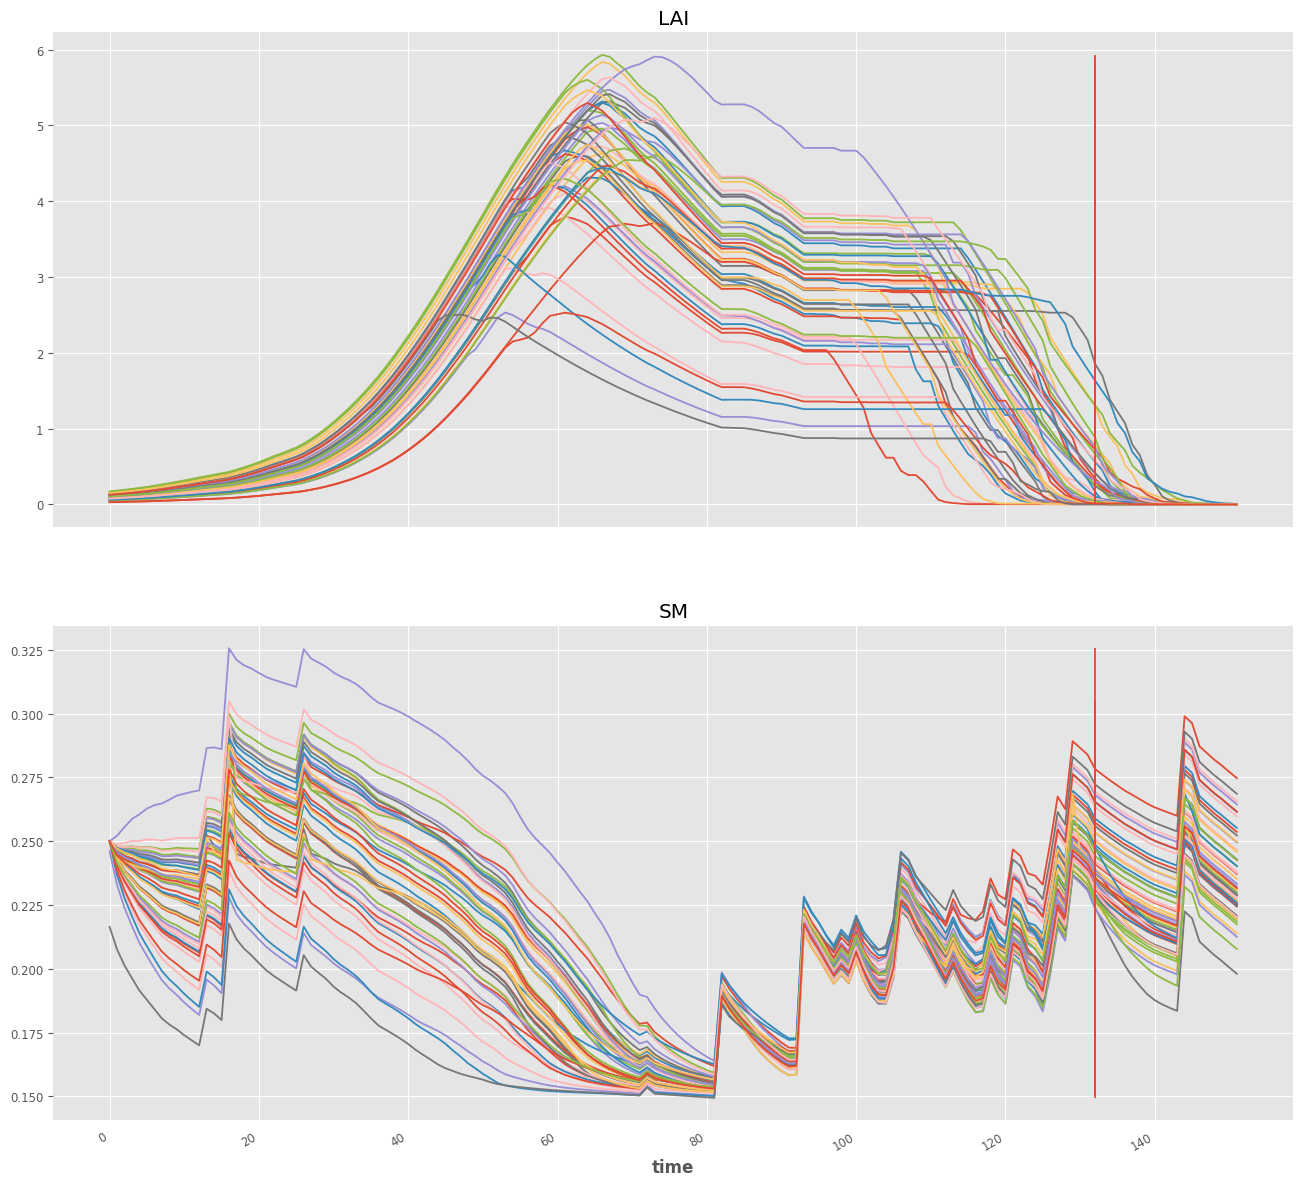

In [199]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
for i, member_df in enumerate(results):
    member_df["LAI"].plot(ax=axes[0])
    member_df["SM"].plot(ax=axes[1])
    axes[0].vlines(x = len(member_df["LAI"].index) - SPLIT, ymin = member_df["LAI"].min(), ymax = member_df["LAI"].max())
    axes[1].vlines(x = len(member_df["SM"].index) - SPLIT, ymin = member_df["SM"].min(), ymax = member_df["SM"].max())
axes[0].set_title("LAI")
axes[1].set_title("SM")
fig.autofmt_xdate()

In [200]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.75)

agg = {
    col: [q1, q2, q3]
    for col in train_cols
}

combined_results = pd.concat(results).groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]
combined_results.reset_index(inplace = True)

combined_preds = pd.concat(pred_dfs).groupby('day').agg(agg)
combined_preds.columns = ['_'.join(col) for col in combined_preds.columns]
combined_preds.reset_index(inplace = True)
combined_preds.index = list(filtered_df.index[-SPLIT:])

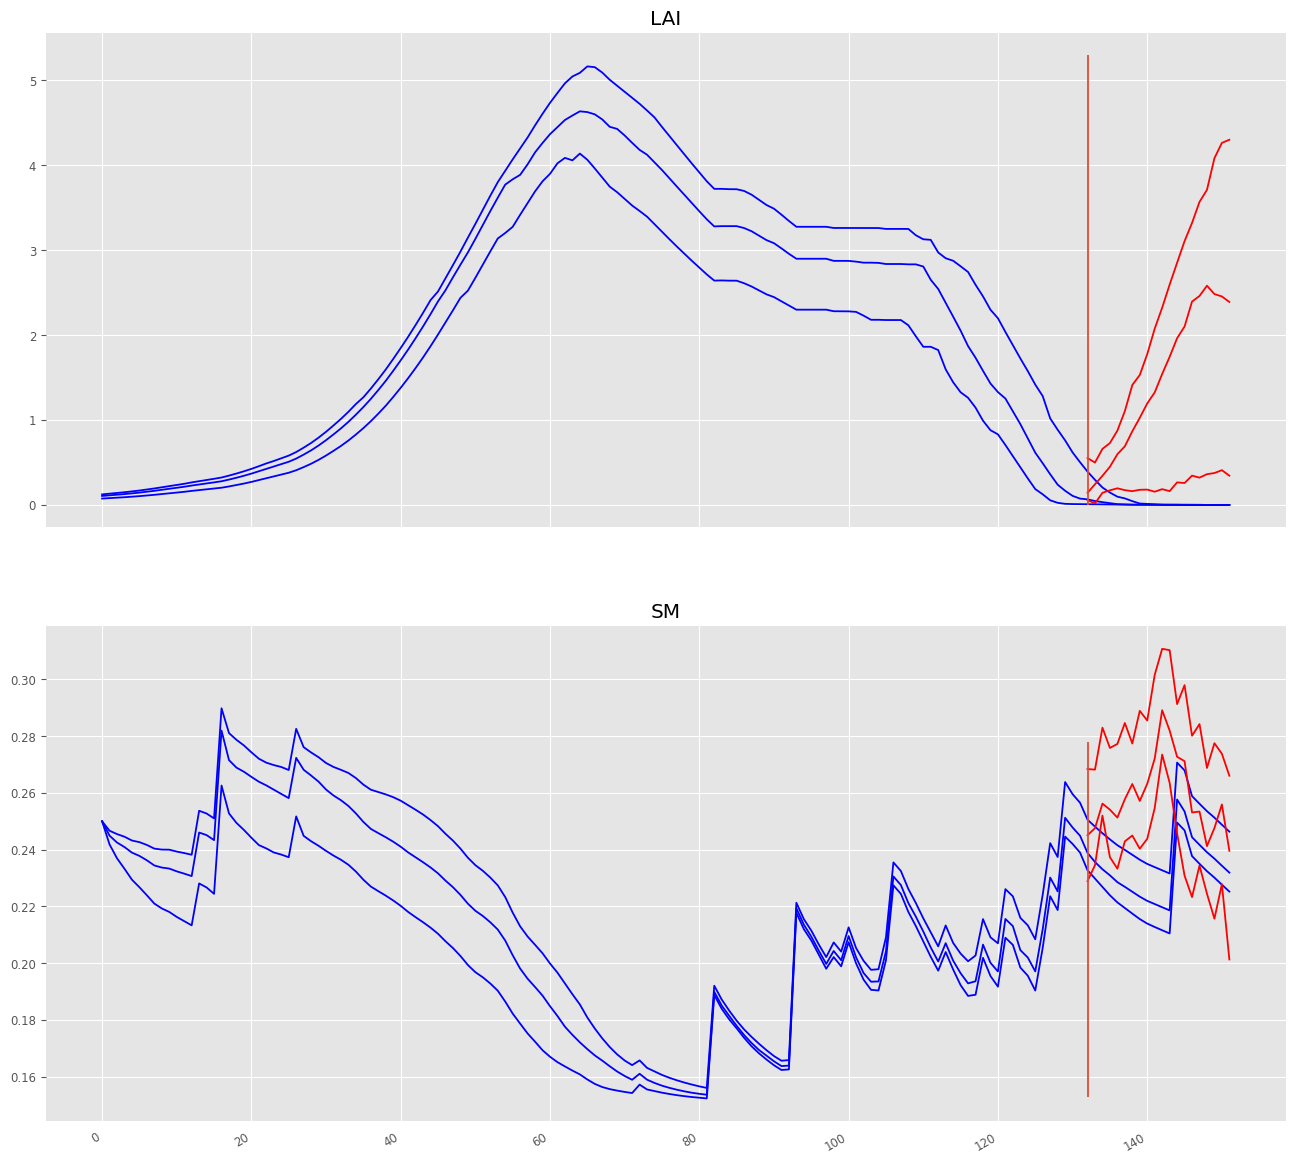

In [201]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)

for df_tuple in [ (combined_results, "blue"), (combined_preds, "red") ]:
    result_df, color = df_tuple
    for i, col in enumerate(train_cols):
        result_df[f"{col}_q1"].plot(ax=axes[i], color = color)
        result_df[f"{col}_q2"].plot(ax=axes[i], color = color)
        result_df[f"{col}_q3"].plot(ax=axes[i], color = color)
            
axes[0].vlines(x = len(member_df[train_cols[0]].index) - SPLIT, ymin = member_df[train_cols[0]].min(), ymax = member_df[train_cols[0]].max())
axes[1].vlines(x = len(member_df["SM"].index) - SPLIT, ymin = member_df["SM"].min(), ymax = member_df["SM"].max())
axes[0].set_title("LAI")
axes[1].set_title("SM")
fig.autofmt_xdate()